In [2]:
import imageio
import gymnasium as gym
import numpy as np
import gym_aloha
import mediapy as media
import torch
from act.policy import ACTPolicy
import mujoco

pygame 2.2.0 (SDL 2.30.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <421678CD-1041-32CD-92EF-29D22242240C> /Users/Eugene/miniconda3/envs/lerobot/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
"""
This scripts demonstrates how to evaluate a pretrained policy from the HuggingFace Hub or from your local
training outputs directory. In the latter case, you might want to run examples/3_train_policy.py first.
"""

from pathlib import Path

import gym_aloha  # noqa: F401
import gymnasium as gym
import imageio
import numpy
import torch
from huggingface_hub import snapshot_download

from lerobot.common.policies.act.modeling_act import ACTPolicy

# Create a directory to store the video of the evaluation
output_directory = Path("lerobot/outputs/eval/act_aloha_sim_transfer_cube_human")
output_directory.mkdir(parents=True, exist_ok=True)

device = torch.device("mps")

# Download the diffusion policy for pusht environment
pretrained_policy_path = Path(snapshot_download("lerobot/act_aloha_sim_transfer_cube_human"))
# OR uncomment the following to evaluate a policy from the local outputs/train folder.
# pretrained_policy_path = Path("outputs/train/example_pusht_diffusion")

policy = ACTPolicy.from_pretrained(pretrained_policy_path)
policy.eval()
policy.to(device)

# Initialize evaluation environment to render two observation types:
# an image of the scene and state/position of the agent. The environment
# also automatically stops running after 300 interactions/steps.
# gym.envs.pprint_registry() to find out what's available
# ("AlohaInsertion-v0", "pixels"),
# ("AlohaInsertion-v0", "pixels_agent_pos"),
# ("AlohaTransferCube-v0", "pixels"),
# ("AlohaTransferCube-v0", "pixels_agent_pos"),
env = gym.make(
    "gym_aloha/AlohaTransferCube-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=300,
)


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Loading weights from local directory


AttributeError: 'MjModel' object has no attribute 'bvh_geomid'

In [31]:

# Reset the policy and environmens to prepare for rollout
policy.reset()
numpy_observation, info = env.reset(seed=69)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []

# Render frame of the initial state
frames.append(env.render())


In [32]:
step = 0
done = False
# while len(frames) < 300:
while not done:
    # Prepare observation for the policy running in Pytorch
    state = torch.from_numpy(numpy_observation["agent_pos"])
    image = torch.from_numpy(numpy_observation["pixels"]["top"])

    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    state = state.to(torch.float32)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1)

    # Send data tensors from CPU to GPU
    state = state.to(device, non_blocking=True)
    image = image.to(device, non_blocking=True)

    # Add extra (empty) batch dimension, required to forward the policy
    state = state.unsqueeze(0)
    image = image.unsqueeze(0)

    # Create the policy input dictionary
    observation = {
        "observation.state": state,
        "observation.images.top": image,
    }

    # Predict the next action with respect to the current observation
    with torch.inference_mode():
        action = policy.select_action(observation)

    # Prepare the action for the environment
    numpy_action = action.squeeze(0).to("cpu").numpy()

    # Step through the environment and receive a new observation
    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    frames.append(env.render())

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

media.show_video(frames, fps=fps)


step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10 reward=0 terminated=False
step=11 reward=0 terminated=False
step=12 reward=0 terminated=False
step=13 reward=0 terminated=False
step=14 reward=0 terminated=False
step=15 reward=0 terminated=False
step=16 reward=0 terminated=False
step=17 reward=0 terminated=False
step=18 reward=0 terminated=False
step=19 reward=0 terminated=False
step=20 reward=0 terminated=False
step=21 reward=0 terminated=False
step=22 reward=0 terminated=False
step=23 reward=0 terminated=False
step=24 reward=0 terminated=False
step=25 reward=0 terminated=False
step=26 reward=0 terminated=False
step=27 reward=0 terminated=False
step=28 reward=0 terminated=False
step=29 reward=0 termina

In [7]:
policy.keys()

odict_keys(['model.pos_table', 'model.transformer.encoder.layers.0.self_attn.in_proj_weight', 'model.transformer.encoder.layers.0.self_attn.in_proj_bias', 'model.transformer.encoder.layers.0.self_attn.out_proj.weight', 'model.transformer.encoder.layers.0.self_attn.out_proj.bias', 'model.transformer.encoder.layers.0.linear1.weight', 'model.transformer.encoder.layers.0.linear1.bias', 'model.transformer.encoder.layers.0.linear2.weight', 'model.transformer.encoder.layers.0.linear2.bias', 'model.transformer.encoder.layers.0.norm1.weight', 'model.transformer.encoder.layers.0.norm1.bias', 'model.transformer.encoder.layers.0.norm2.weight', 'model.transformer.encoder.layers.0.norm2.bias', 'model.transformer.encoder.layers.1.self_attn.in_proj_weight', 'model.transformer.encoder.layers.1.self_attn.in_proj_bias', 'model.transformer.encoder.layers.1.self_attn.out_proj.weight', 'model.transformer.encoder.layers.1.self_attn.out_proj.bias', 'model.transformer.encoder.layers.1.linear1.weight', 'model.t

In [10]:

env = gym.make("gym_aloha/AlohaInsertion-v0")
observation, info = env.reset()
frames = []

for _ in range(1000):
    action = policy.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    image = env.render()
    frames.append(image)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

media.show_video(frames, fps=25)

AttributeError: 'collections.OrderedDict' object has no attribute 'predict'

In [3]:
import mujoco
import numpy as np
import mediapy as media
from pathlib import Path
# np.set_printoptions(precision=10, suppress=True, linewidth=100)


""

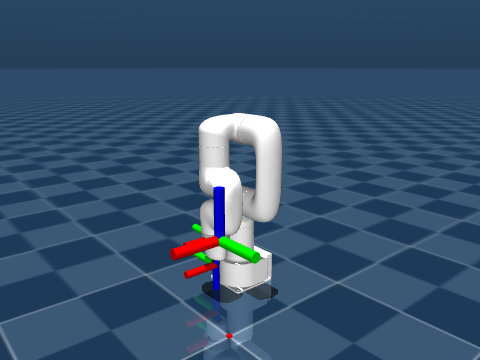

In [4]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model, height=360, width=480)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

# Visualize site frames and labels
voption = mujoco.MjvOption()
voption.frame = mujoco.mjtFrame.mjFRAME_SITE
renderer.update_scene(data, camera, scene_option=voption)

media.show_image(renderer.render())


## Task
Pick up, put down

In [23]:
import gym_lite6.env
from importlib import reload


,

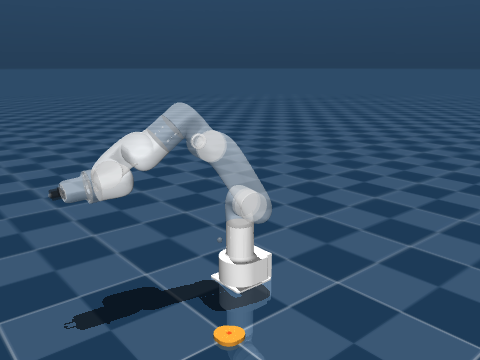
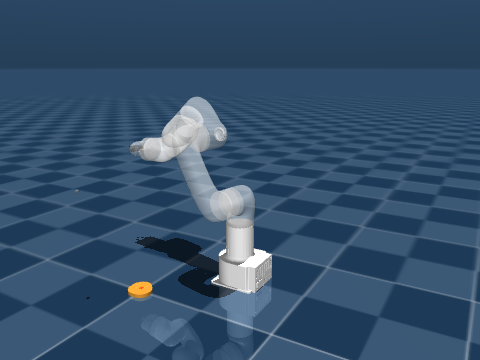

In [8]:

camera2 = mujoco.MjvCamera()
camera2.distance = 1.2
camera2.elevation = -15
camera2.azimuth = -60
camera2.lookat = (0, 0, 0.3)

voption = mujoco.MjvOption()
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
voption.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
voption.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
renderer.update_scene(data, camera, scene_option=voption)
f1 = renderer.render()
renderer.update_scene(data, camera2, scene_option=voption)
f2 = renderer.render()
media.show_images([f1, f2])


,,,,,

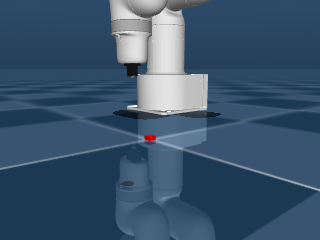
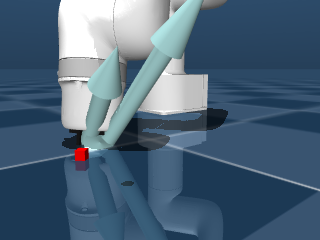
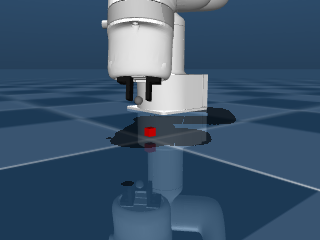
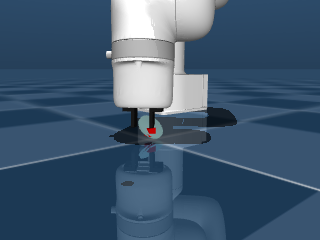
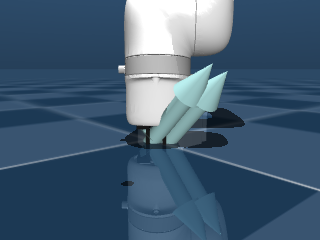
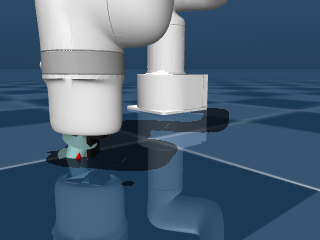

AssertionError: Reward is 2, contacts: [[19 18]]

In [25]:
# Test IK from env

pos = np.array([0.2, 0.2, 0.2])
quat = np.array([0, 1, 0, 0])
qpos = env.unwrapped.solve_ik(pos, quat)
print(qpos)


Terminated after 10 iterations: norm(dx) < tol. y: 2.143e-20, Residual evals: 47, Jacobian evals: 11
total time 5.8ms of which residual 56.8% Jacobian 15.7%
[0.7854 0.2893 1.1088 0.     0.8195 0.7854]


In [13]:
target_quat = np.array([0., 1., 0., 0.])
ref_quat = np.array([0., 1., 0., 0.])
Deffector = np.empty((3, 3))
mujoco.mjd_subQuat(target_quat, ref_quat, None, Deffector)

In [14]:
assert(np.allclose(env.unwrapped.map_bounds(vals=np.array([0, 0.5, 1]), in_range=np.array([[0, 1], [0, 1], [0, 1]]), out_range=np.array([[-1, 1], [-1, 1], [-1, 1]])), np.array([-1, 0, 1])) )

""

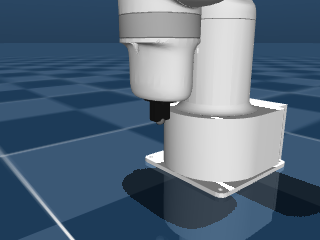

In [15]:
media.show_image(observation['pixels'])

## Record episodes

In [225]:
record_episodes(env, None, "dataset/test/", len=10)

Episode 0
action
qpos
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
gripper
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
observation
qpos
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
gripper
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
reward
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
<HDF5 file "ep_0.hdf5" (mode r+)>


In [235]:
with h5py.File("dataset/test/ep_0.hdf5", "r") as f:
    for name in f:
        print(f[name])
    print(f["reward"][0])

<HDF5 group "/action" (2 members)>
<HDF5 group "/observation" (2 members)>
<HDF5 dataset "reward": shape (10,), type "<i8">
2


In [79]:
data.contact[0].efc_address

9

In [80]:
data.efc_force[data.contact[0].efc_address]

1.6576580411150468

""

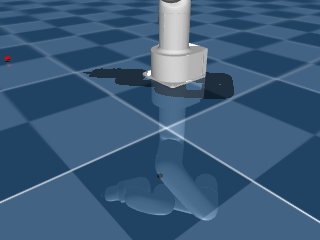

array([[17, 18]], dtype=int32)

In [117]:
reload(gym_lite6.env)
env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
)
observation, info = env.reset()
media.show_image(env.render())
env.data.contact.geom


In [85]:
env.data.geom(19)

<_MjDataGeomViews
  id: 19
  name: 'box'
  xmat: array([-0.67879527,  0.26327446,  0.68550969,  0.73208799,  0.3154752 ,
        0.60375704, -0.05730749,  0.91168084, -0.40688315])
  xpos: array([0.69978493, 0.10409714, 0.        ])
>

In [13]:
scene_path = "models/cube_pickup.xml"
model = mujoco.MjModel.from_xml_path(scene_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

[0.20244837 0.20241317 0.10725087]


""

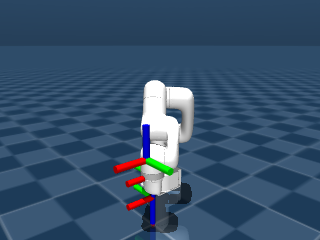

[0.2025 0.2025 0.1075]


In [18]:
mujoco.mj_resetData(model, data)
data.ctrl[:6] = np.array([0.785399277 , 0.5525638469, 1.0265586618, 0.0000054301, 0.4739905706, 0.7854002379])
for i in range(500):
  mujoco.mj_step(model, data)
print(data.site('end_effector').xpos)
renderer.update_scene(data, camera, voption); media.show_image(renderer.render())
data.qpos[:6] = np.array([0.785399277 , 0.5525638469, 1.0265586618, 0.0000054301, 0.4739905706, 0.7854002379])
mujoco.mj_step(model, data)
print(data.site('end_effector').xpos)
